In [789]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from scipy.special import inv_boxcox
from scipy.stats import boxcox

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import pickle

#### Data Cleaning / Feature engineering / Preprocessing

In [638]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [639]:
# verify no duplicate / nulls

print("train duplicated: {}".format(train.duplicated().sum()))
print("test duplicated: {}".format(test.duplicated().sum()))
print("train nulls: {}".format(train.isnull().any().sum()))
print("test nulls: {}".format(test.isnull().any().sum()))

train duplicated: 0
test duplicated: 0
train nulls: 0
test nulls: 0


In [640]:
train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10556,2012-12-06 06:00:00,4,0,1,1,9.02,10.605,55,19.9995,2,122,124
1397,2011-04-04 02:00:00,2,0,1,1,15.58,19.695,66,16.9979,1,1,2
3942,2011-09-15 07:00:00,3,0,1,2,25.42,29.545,78,12.9980,17,321,338
8209,2012-07-03 10:00:00,3,0,1,1,33.62,37.120,43,15.0013,56,153,209
3811,2011-09-09 19:00:00,3,0,1,1,27.06,29.545,89,11.0014,33,316,349


In [641]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [802]:
def datetime_breakdown(data, column_name):
    df = data.copy()
    df[column_name] = df[column_name].apply(pd.to_datetime, format = '%Y-%m-%d')
    df[column_name + '_year'] = df[column_name].dt.year
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_day'] = df[column_name].dt.day
    df[column_name + '_hour'] = df[column_name].dt.hour
    return df.drop(column_name, axis = 1)

In [643]:
train = datetime_breakdown(train, 'datetime')

In [644]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_year,datetime_month,datetime_day,datetime_hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [645]:
def plot_boxplots(data):
    nrows = (len(data.columns) // 4) + 1
    plt.figure(figsize=(25, nrows * 5))
    sns.set(font_scale = 1)
    columns = data.columns
    for i in range(len(columns)):
        plt.subplot(nrows, 4, i+1)
        sns.boxplot(y = data[columns[i]])  
        
def plot_histograms(data):
    nrows = (len(data.columns) // 4) + 1
    plt.figure(figsize=(25, nrows * 5))
    sns.set(font_scale = 1)
    columns = data.columns
    for i in range(len(columns)):
        plt.subplot(nrows, 4, i+1)
        sns.histplot(x = data[columns[i]])  

In [77]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_year,datetime_month,datetime_day,datetime_hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000


In [817]:
# assumes that datetime starts from 0 to max_datetime - 1. eg. hour ranges from 0 to 23, not 1 to 24
# only works properly for month, day, hour

def cyclic_datetime(data, column_name, datetime_type):
    df = data.copy()
    divided_by = 0
    if datetime_type == 'hour':
        divided_by = 24
        df['sin_' + column_name] = np.sin(df[column_name] * (2 * np.pi / divided_by)) # no need to -1 since min hour = 0
        df['cos_' + column_name] = np.cos(df[column_name] * (2 * np.pi / divided_by))
    else:
        if datetime_type == 'month':
            divided_by = 12
        if datetime_type == 'day': 
            divided_by = 30
        df['sin_' + column_name] = np.sin((df[column_name] - 1) * (2 * np.pi / divided_by)) # -1 since min day / min month = 1
        df['cos_' + column_name] = np.cos((df[column_name] - 1) * (2 * np.pi / divided_by))
    df = df.drop(column_name, axis = 1)
    return df

In [820]:
times = ['datetime_month', 'datetime_hour', 'datetime_day']
datetime_type = ['month', 'hour', 'day']
train_after_date = train.copy()
for i in range(0, len(times)):
    train_after_date = cyclic_datetime(train_after_date, times[i], datetime_type[i])

In [821]:
train_after_date.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count',
       'datetime_year', 'sin_datetime_month', 'cos_datetime_month',
       'sin_datetime_hour', 'cos_datetime_hour', 'sin_datetime_day',
       'cos_datetime_day'],
      dtype='object')

In [649]:
# drop registered and casual since they add up to count
continuous_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'sin_datetime_month',
                        'cos_datetime_month', 'sin_datetime_hour', 'cos_datetime_hour', 
                        'sin_datetime_day', 'cos_datetime_day', 'count']
categorical_variables = ['season', 'holiday', 'workingday', 'weather', 'datetime_year']

In [650]:
train_after_date = train_after_date[continuous_variables + categorical_variables]

In [651]:
train_after_date.head()

,temp,atemp,humidity,windspeed,sin_datetime_month,cos_datetime_month,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,count,season,holiday,workingday,weather,datetime_year
0,9.84,14.395,81,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,16,1,0,0,1,2011
1,9.02,13.635,80,0.0,0.0,1.0,0.258819,0.965926,0.0,1.0,40,1,0,0,1,2011
2,9.02,13.635,80,0.0,0.0,1.0,0.500000,0.866025,0.0,1.0,32,1,0,0,1,2011
3,9.84,14.395,75,0.0,0.0,1.0,0.707107,0.707107,0.0,1.0,13,1,0,0,1,2011
4,9.84,14.395,75,0.0,0.0,1.0,0.866025,0.500000,0.0,1.0,1,1,0,0,1,2011


In [652]:
train_continuous = train_after_date[continuous_variables]

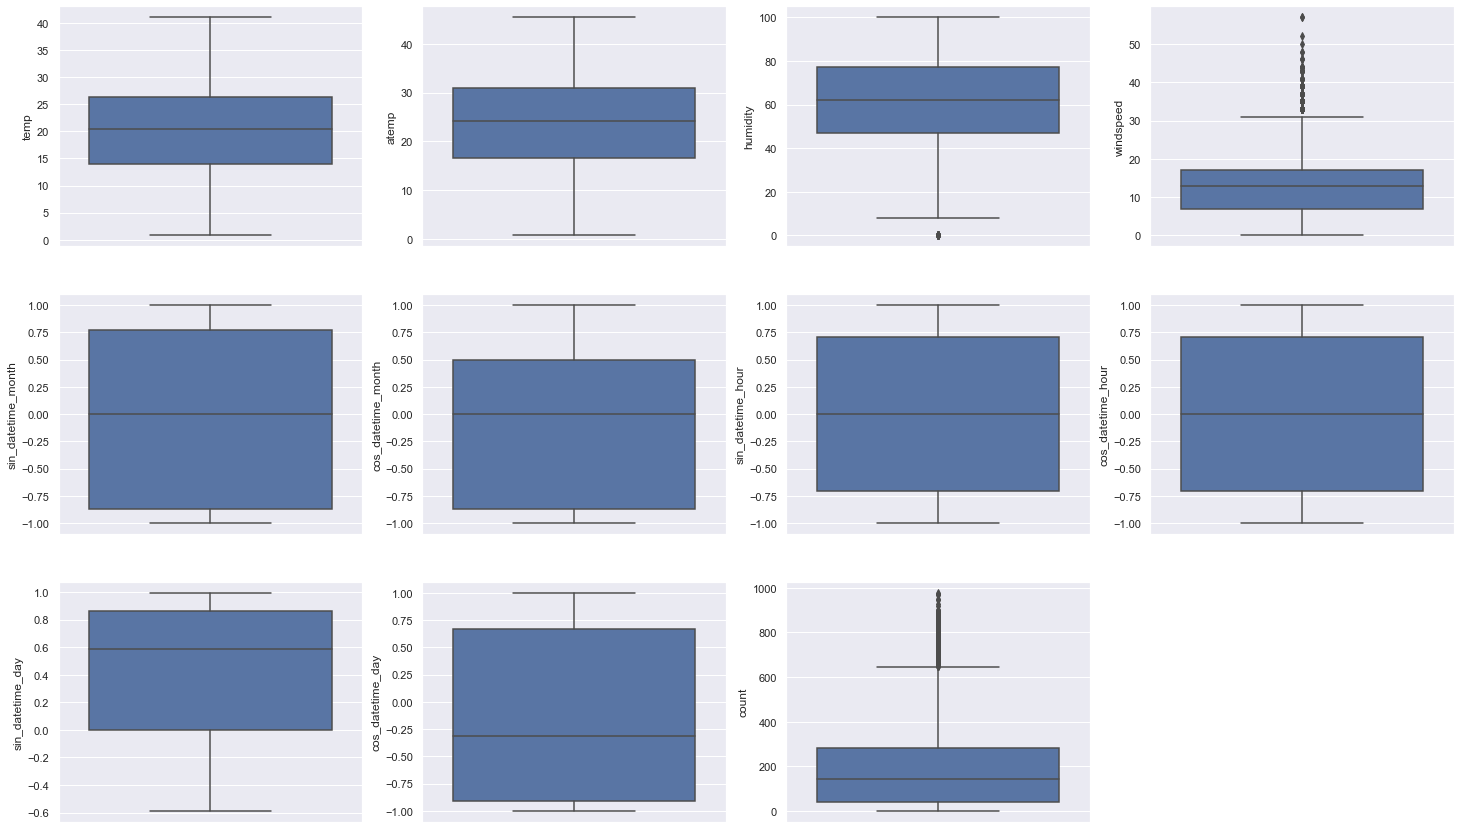

In [653]:
plot_boxplots(train_continuous)

# windspeed and cnt have numerous outliers 

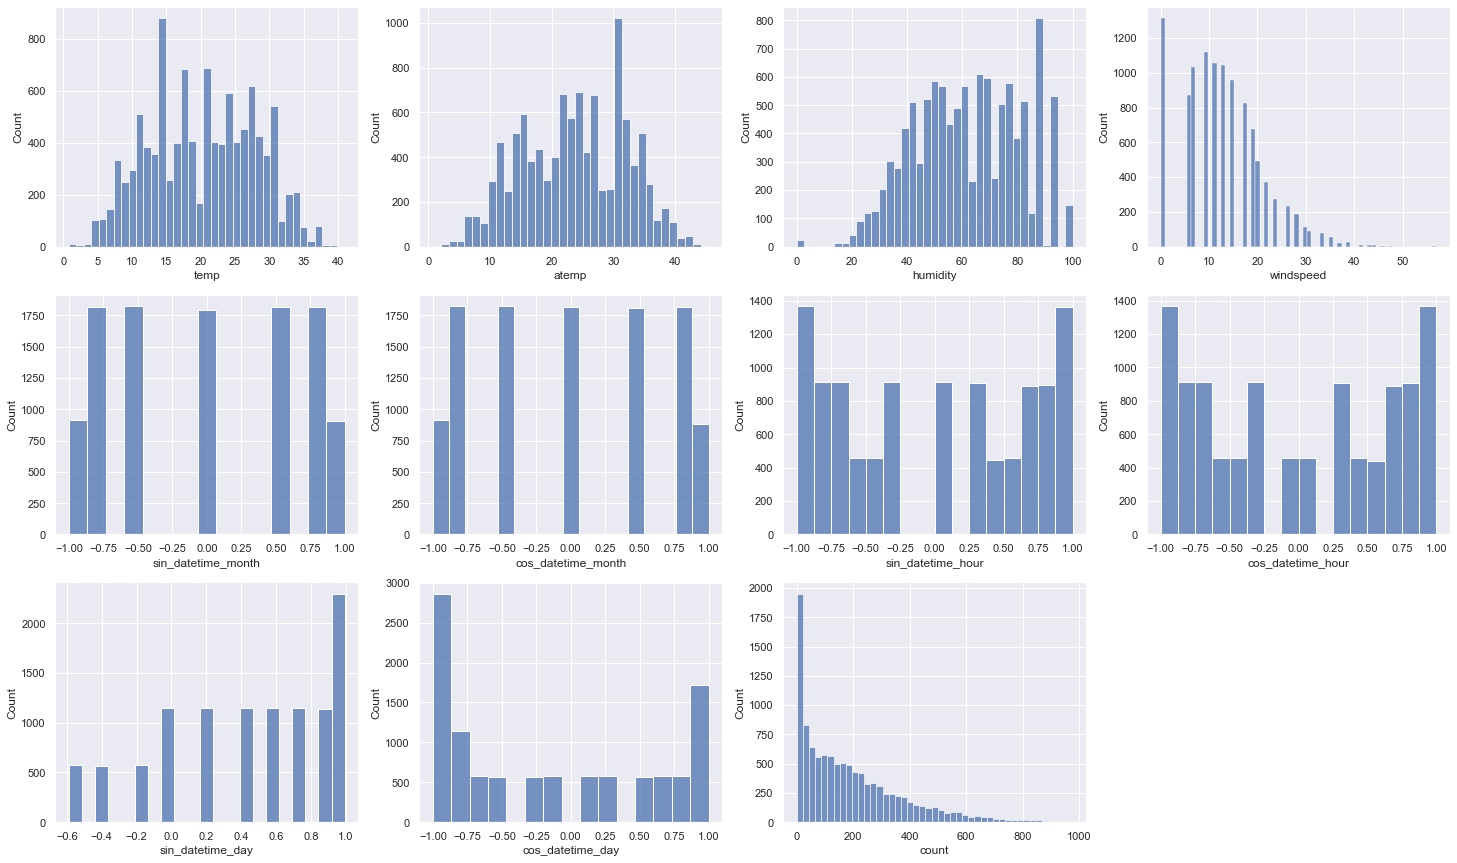

In [654]:
plot_histograms(train_continuous)

Observations:
- Boxplot:
    - windspeed and count have many outliers 
    - humidity = 0? 
- Histograms:
    - windspeed and count are quite skewed

In [655]:
def identify_outliers(data, feature):
    percentile25 = data[feature].quantile(0.25)
    percentile75 = data[feature].quantile(0.75)
    iqr = percentile75 - percentile25
    upper = percentile75 + 1.5 * iqr
    lower = percentile25 - 1.5 * iqr
    return data[(data[feature] < lower) | (data[feature] > upper)]

def remove_outliers(data, feature):
    percentile25 = data[feature].quantile(0.25)
    percentile75 = data[feature].quantile(0.75)
    iqr = percentile75 - percentile25
    upper = percentile75 + 1.5 * iqr
    lower = percentile25 - 1.5 * iqr
    return data[(data[feature] >= lower) & (data[feature] <= upper)]

In [656]:
X_train_continuous = train_after_date[continuous_variables].drop('count', axis = 1)
y_train = train_after_date[['count']]

In [657]:
scaled_continuous = StandardScaler().fit(X_train_continuous)

In [658]:
X_train_scaled_continuous = pd.DataFrame(scaled_continuous.transform(X_train_continuous))

In [659]:
X_train_scaled_continuous.columns = scaled_continuous.feature_names_in_

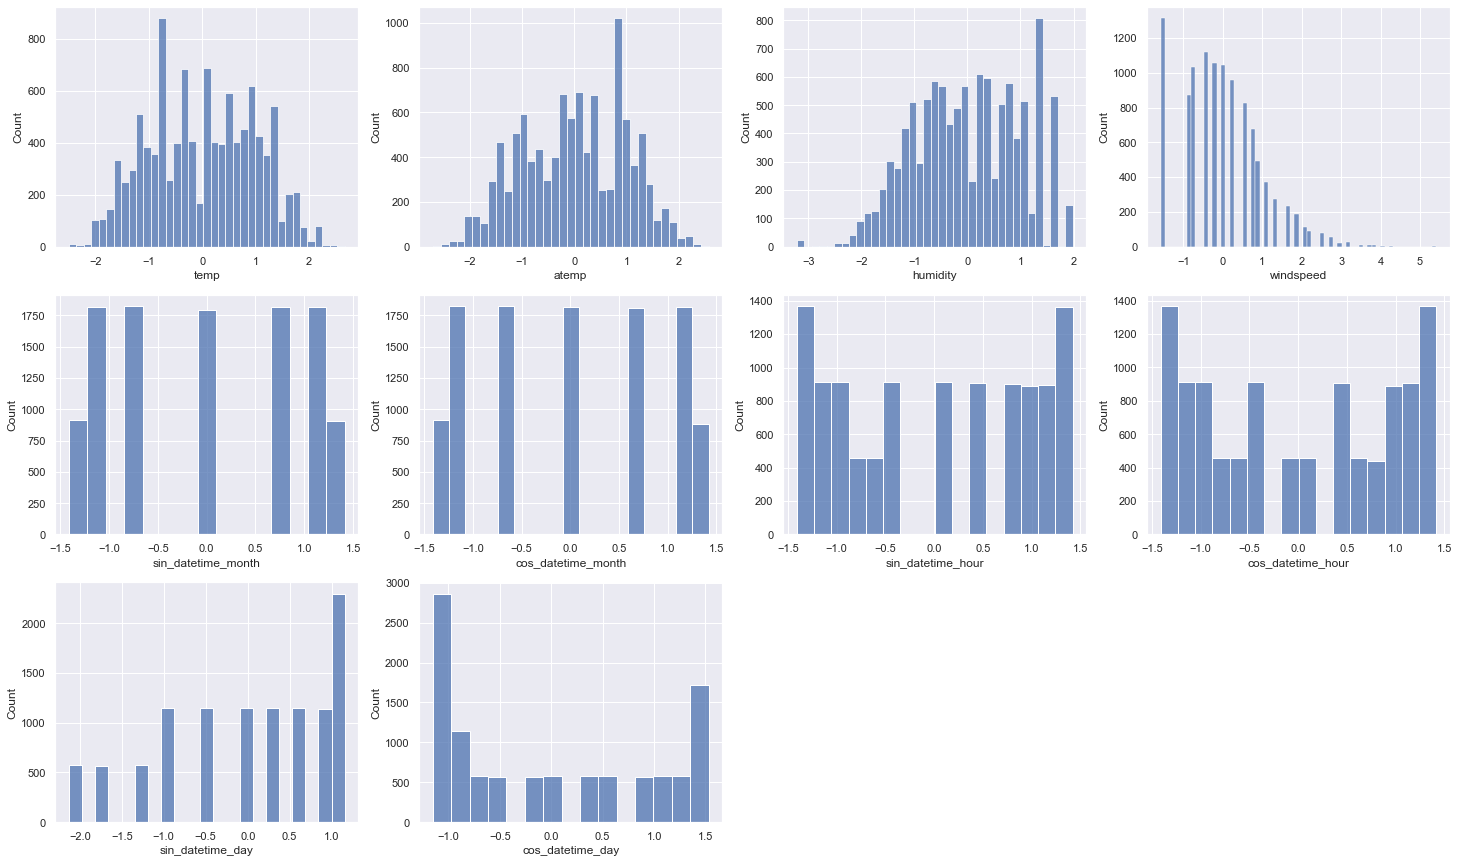

In [660]:
plot_histograms(X_train_scaled_continuous) # windspeed still quite skewed

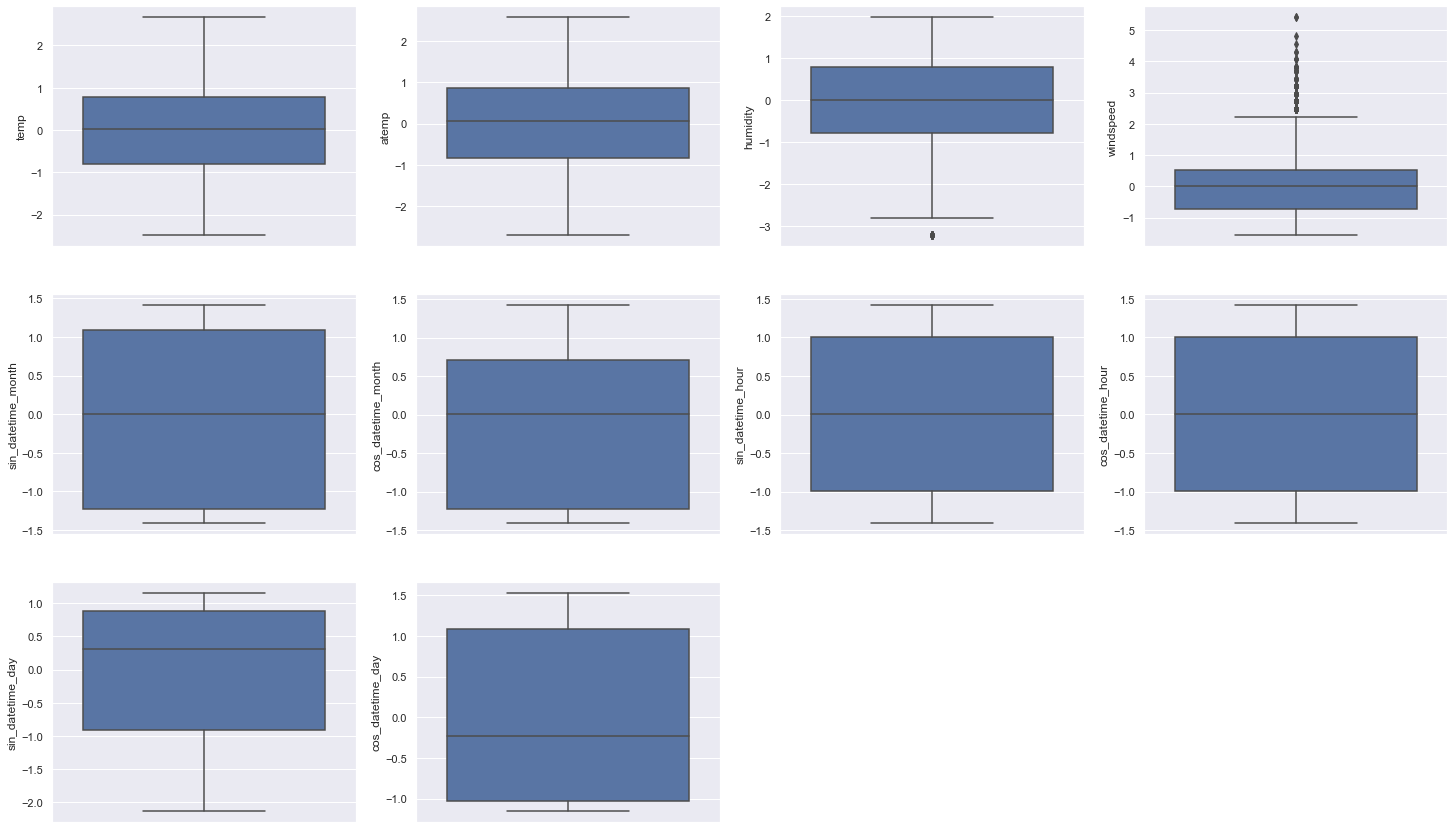

In [661]:
plot_boxplots(X_train_scaled_continuous) # consider transforming windspeed to reduce number of outliers

In [662]:
# print("Num outliers for temp: {}".format(len(identify_outliers(bike_continuous, 'temp'))))
# print("Num outliers for cnt: {}".format(len(identify_outliers(bike_continuous, 'cnt'))))
# print("Num outliers for hum: {}".format(len(identify_outliers(bike_continuous, 'hum'))))
print("Num outliers for windspeed: {}".format(len(identify_outliers(X_train_scaled_continuous, 'windspeed'))))

Num outliers for windspeed: 227


In [663]:
print("Num outliers for windspeed: {}".format(len(identify_outliers(np.cbrt(X_train_scaled_continuous[['windspeed']] + 2), 'windspeed')))) 
# after trying log, log(x+1), sqrt(x + 1), sqrt

Num outliers for windspeed: 29


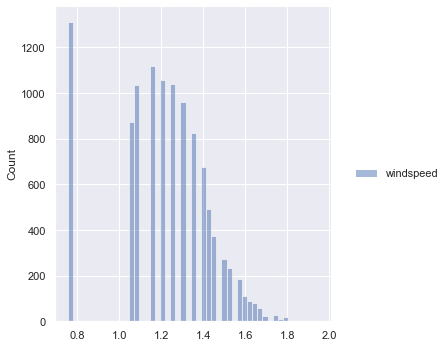

In [664]:
sns.displot(np.cbrt(X_train_scaled_continuous[['windspeed']] + 2))
plt.show()

In [665]:
y_train_boxcox, y_lamd = boxcox(y_train['count'])

In [666]:
y_train_boxcox = pd.DataFrame(y_train_boxcox).rename({0 : 'count'}, axis = 1)

In [667]:
print("Num outliers for count: {}".format(len(identify_outliers(y_train_boxcox, 'count'))))

Num outliers for count: 0


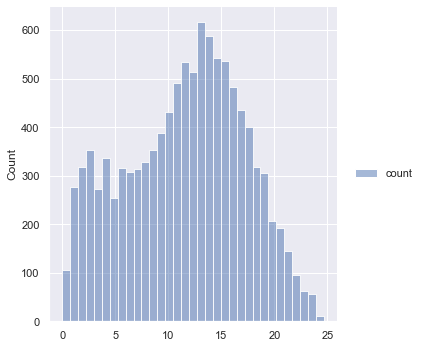

In [668]:
sns.displot(y_train_boxcox)
plt.show() 
# a lot more normally distributed

In [669]:
X_train_scaled_continuous['windspeed'] = np.cbrt(X_train_scaled_continuous['windspeed'] + 2)

In [670]:
# encode categorical variables 
train_scaled = pd.concat([X_train_scaled_continuous, 
                          pd.get_dummies(train_after_date[categorical_variables].astype('category'), drop_first = True), 
                          y_train_boxcox], axis = 1)

In [682]:
scaled_continuous_variables = list(train_scaled.columns)[:10] + [train_scaled.columns[-1]]
scaled_categorical_variables = list(train_scaled.columns)[10:-1]

In [685]:
# Find Point biserial correlation
def point_biserial_correl(data, categorical_variables, continuous_variables):
    print("--- point biserial ---")
    for cat_var in categorical_variables:
        for cont_var in  continuous_variables:
            data_cat = data[cat_var].to_numpy()
            data_cont = data[cont_var].to_numpy()

            corr, p_val = pointbiserialr(x=data_cat, y=data_cont)
            if np.abs(corr) >= 0.75:
                print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')

In [686]:
# Find Cramer's V correlation
def cramer_v_correl(data, categorical_variables):
    print("--- cramer v ---")
    total_len = len(categorical_variables)
    for idx1 in range(total_len-1):
        for idx2 in range(idx1+1, total_len):
            cat_var1 = categorical_variables[idx1]
            cat_var2 = categorical_variables[idx2]    
            c_matrix = pd.crosstab(data[cat_var1], data[cat_var2])
            chi2 = chi2_contingency(c_matrix)[0]
            n = c_matrix.sum().sum()
            phi2 = chi2/n
            r,k = c_matrix.shape
            phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
            rcorr = r-((r-1)**2)/(n-1)
            kcorr = k-((k-1)**2)/(n-1)
            corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
            if corr >= 0.75:
                print(f'categorical variable 1 {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')

In [687]:
# Find Pearson correlation
def pearson_correl(data, continuous_variables):
    print("--- pearson ---")
    total_len = len(continuous_variables)
    for idx1 in range(total_len-1):
        for idx2 in range(idx1+1, total_len):
            cont_var1 = continuous_variables[idx1]
            cont_var2 = continuous_variables[idx2]
            data_cont1 = data[cont_var1].to_numpy()
            data_cont2 = data[cont_var2].to_numpy()
            corr, p_val = pearsonr(x=data_cont1, y=data_cont2)
            if np.abs(corr) >= 0.75:
                print(f'Variable 1: {cont_var1}, Variable 2: {cont_var2}, correlation: {corr}')

In [688]:
point_biserial_correl(train_scaled, scaled_categorical_variables, scaled_continuous_variables)
cramer_v_correl(train_scaled, scaled_categorical_variables)
pearson_correl(train_scaled, scaled_continuous_variables)

--- point biserial ---
--- cramer v ---
--- pearson ---
Variable 1: temp, Variable 2: atemp, correlation: 0.9849481104817072
Variable 1: temp, Variable 2: cos_datetime_month, correlation: -0.8560196876577529
Variable 1: atemp, Variable 2: cos_datetime_month, correlation: -0.8380928348221114


In [689]:
# drop because of correlation : 'sin_datetime_month', 'cos_datetime_month', 'atemp'
train_after_corr = train_scaled.drop(['atemp', 'cos_datetime_month', 'sin_datetime_month'], axis = 1)


In [690]:
print(scaled_continuous_variables)
print(scaled_categorical_variables)

['temp', 'atemp', 'humidity', 'windspeed', 'sin_datetime_month', 'cos_datetime_month', 'sin_datetime_hour', 'cos_datetime_hour', 'sin_datetime_day', 'cos_datetime_day', 'count']
['season_2', 'season_3', 'season_4', 'holiday_1', 'workingday_1', 'weather_2', 'weather_3', 'weather_4', 'datetime_year_2012']


In [694]:
train_after_corr.columns

Index(['temp', 'humidity', 'windspeed', 'sin_datetime_hour',
       'cos_datetime_hour', 'sin_datetime_day', 'cos_datetime_day', 'season_2',
       'season_3', 'season_4', 'holiday_1', 'workingday_1', 'weather_2',
       'weather_3', 'weather_4', 'datetime_year_2012', 'count'],
      dtype='object')

In [696]:
continuous_variables_after_corr = list(train_after_corr.columns[0:7]) + [train_after_corr.columns[-1]]
categorical_variables_after_corr = list(train_after_corr.columns[7:-1])

In [699]:
train_after_corr.head()

,temp,humidity,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012,count
0,-1.333661,0.993213,0.756096,0.005336,1.417926,-0.908872,1.530378,0,0,0,0,0,0,0,0,0,4.433145
1,-1.438907,0.941249,0.756096,0.371447,1.369748,-0.908872,1.530378,0,0,0,0,0,0,0,0,0,6.982674
2,-1.438907,0.941249,0.756096,0.712607,1.228497,-0.908872,1.530378,0,0,0,0,0,0,0,0,0,6.292274
3,-1.333661,0.681430,0.756096,1.005568,1.003799,-0.908872,1.530378,0,0,0,0,0,0,0,0,0,3.950910
4,-1.333661,0.681430,0.756096,1.230365,0.710967,-0.908872,1.530378,0,0,0,0,0,0,0,0,0,0.000000


In [700]:
point_biserial_correl(train_after_corr, categorical_variables_after_corr, continuous_variables_after_corr)
cramer_v_correl(train_after_corr, categorical_variables_after_corr)
pearson_correl(train_after_corr, continuous_variables_after_corr)

--- point biserial ---
--- cramer v ---
--- pearson ---


In [701]:
train_after_corr = remove_outliers(train_after_corr, 'windspeed')
train_after_corr = remove_outliers(train_after_corr, 'humidity')

In [702]:
def check_vif(data):
    vif = pd.DataFrame()
    vif["feature"] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    print(vif.sort_values(by = 'VIF', ascending = False))

In [703]:
check_vif(train_after_corr[continuous_variables_after_corr].drop('count', axis = 1))

             feature       VIF
1           humidity  1.282705
3  sin_datetime_hour  1.227984
4  cos_datetime_hour  1.124940
5   sin_datetime_day  1.121782
6   cos_datetime_day  1.120445
0               temp  1.064076
2          windspeed  1.002779


In [704]:
X_train = train_after_corr.drop('count', axis = 1)
y_train = train_after_corr['count'] + 1 # no negative values for a scoring metric of RMSLE

In [451]:
X_train.head()

,temp,humidity,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4
0,-1.333661,0.993213,0.756096,0.005336,1.417926,-0.908872,1.530378,0,0,0,0,0,0,0,0
1,-1.438907,0.941249,0.756096,0.371447,1.369748,-0.908872,1.530378,0,0,0,0,0,0,0,0
2,-1.438907,0.941249,0.756096,0.712607,1.228497,-0.908872,1.530378,0,0,0,0,0,0,0,0
3,-1.333661,0.681430,0.756096,1.005568,1.003799,-0.908872,1.530378,0,0,0,0,0,0,0,0
4,-1.333661,0.681430,0.756096,1.230365,0.710967,-0.908872,1.530378,0,0,0,0,0,0,0,0


In [452]:
y_train

0         5.433145
1         7.982674
2         7.292274
3         4.950910
4         1.000000
           ...    
10881    17.704819
10882    15.725759
10883    13.799393
10884    12.521965
10885    10.851258
Name: count, Length: 10835, dtype: float64

### Multiple Linear Regression

In [705]:
mlr_cv = cross_val_score(LinearRegression(), X_train, y_train, scoring = 'neg_mean_squared_log_error', cv = 5)

In [706]:
print("best cv rmsle: {}".format(np.sqrt(np.mean(-mlr_cv))))

best cv rmsle: 0.3352257701755564


### Lasso Regression

In [707]:
lasso = Lasso(max_iter = 10000)
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000)
lassocv.fit(X_train, y_train)

LassoCV(cv=5, max_iter=100000)

In [708]:
lasso_cv = cross_val_score(lasso.set_params(alpha = lassocv.alpha_), X_train, y_train, scoring = 'neg_mean_squared_log_error', cv = 5)

In [709]:
print("best cv rmsle: {}".format(np.sqrt(np.mean(-lasso_cv))))

best cv rmsle: 0.33542216311034967


In [ ]:
# Lasso zeroes out 4 predictors and has a better test score than vanilla linear regression

### Decision Tree

In [710]:
dectree = DecisionTreeRegressor(random_state = 42)

In [711]:
dectree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [712]:
dectree.get_depth()

30

In [713]:
dectree.score(X_train, y_train) # need to prune

0.9999988547219815

In [714]:
param_grid = [
    {'max_depth' : [10, 15, 20, 25, 30]}
]
     
dectree = DecisionTreeRegressor(random_state = 42)    
dectree_cv = GridSearchCV(dectree, param_grid, cv = 5, scoring = 'neg_mean_squared_log_error')
dectree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_depth': [10, 15, 20, 25, 30]}],
             scoring='neg_mean_squared_log_error')

In [715]:
# print("best cv r2: {}".format(dectree_cv.best_score_))
print("best param: {}".format(dectree_cv.best_params_))

best param: {'max_depth': 10}


In [716]:
param_grid = [
    {'max_depth' : range(1, 15)}
]
     
dectree = DecisionTreeRegressor(random_state = 42)    
dectree_cv = GridSearchCV(dectree, param_grid, cv = 5, scoring = 'neg_mean_squared_log_error')
dectree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_depth': range(1, 15)}],
             scoring='neg_mean_squared_log_error')

In [717]:
print("best cv rmsle: {}".format(np.sqrt(-dectree_cv.best_score_)))
print("best param: {}".format(dectree_cv.best_params_))

best cv rmsle: 0.2340296459610564
best param: {'max_depth': 9}


### Random Forest / Bagging

In [722]:
n_trees = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
oob_scores = []

In [723]:
for ntree in n_trees:
    rf = RandomForestRegressor(n_estimators = ntree, oob_score = True, n_jobs = -1, random_state = 42).fit(X_train.values, y_train.values)
    oob_scores.append(rf.oob_score_)

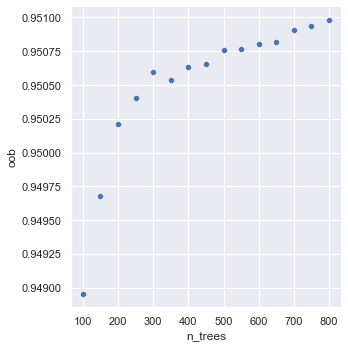

In [724]:
sns.relplot(x = n_trees, y = oob_scores).set_axis_labels("n_trees", "oob")
plt.show()

In [725]:
param_grid = {
    'max_features':["auto",'sqrt','log2']
}
# although 800 gives the best result, the more trees, the greater the computational cost. Since the gains are marginal, I will just go with 300
rf = RandomForestRegressor(n_estimators = 300, random_state = 42) 
rf_cv = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_log_error')
rf_cv.fit(X_train.values, y_train.values)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=300, random_state=42),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_log_error')

In [726]:
print("best cv rmsle : {}".format(np.sqrt(-rf_cv.best_score_)))
print("best param: {}".format(rf_cv.best_params_)) # bagging is chosen

best cv rmsle : 0.19955016106430265
best param: {'max_features': 'auto'}


### Gradient Boosting

In [727]:
xgbreg = xgb.XGBRegressor(eval_metric = mean_squared_log_error, random_state = 42, use_label_encoder = False, verbosity = 0)

param_grid = {
        'max_depth': range(2, 11),
        'min_child_weight' : range(1,10,1),
        'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'subsample': [i/10.0 for i in range(3,10)],
        'colsample_bytree': [i/10.0 for i in range(3,10)],
        'min_child_weight': range(1, 10),
        'gamma': [i/10.0 for i in range(0,5)],
        'n_estimators': range(100, 1500, 100)
}

In [728]:
xgbreg_cv = RandomizedSearchCV(xgbreg, param_grid, n_iter=25,
                               n_jobs=-1, cv=5, scoring='neg_mean_squared_log_error', random_state=42)
xgbreg_cv.fit(X_train, y_train)
# print("best cv rmsle: {}".format(np.sqrt(-xgbreg_cv.best_score_)))
# best_params = xgbreg_cv.best_params_
# print("best params: ")
# for param_name in sorted(best_params.keys()):
#     print('%s: %r' % (param_name, best_params[param_name]))

C:\Users\Jeffrey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.04063643 -0.03781523 -0.15231489 -0.03724757 -0.02750765 -0.07419327
 -0.08892827 -0.03233445         nan -0.03001481         nan -0.0296638
         nan         nan         nan -0.08892652         nan -0.04991412
 -0.03172609 -0.13783604         nan         nan -0.0643729          nan
 -0.03364805]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False,
                                          eval_metric=<function mean_squared_log_error at 0x00000250A8C52550>,
                                          gamma=None, gpu_id=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_d...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                

In [729]:
xgbreg_cv.best_params_

{'subsample': 0.6,
 'n_estimators': 1300,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning_rate': 0.03,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [730]:
np.sqrt(-xgbreg_cv.best_score_)

0.16585429047739

In [731]:
cvs = [np.sqrt(np.mean(-mlr_cv)), np.sqrt(np.mean(-lasso_cv)), np.sqrt(-dectree_cv.best_score_), np.sqrt(-rf_cv.best_score_), np.sqrt(-xgbreg_cv.best_score_)]
model = ['Linear reg', 'Lasso reg', 'Decision Tree', 'Bagging', 'XGBoost']

In [732]:
model_performances = pd.DataFrame(data = {'Model' : model, 'CV score' : cvs})
model_performances.sort_values(by = 'CV score')

,Model,CV score
4,XGBoost,0.165854
3,Bagging,0.199550
2,Decision Tree,0.234030
0,Linear reg,0.335226
1,Lasso reg,0.335422


#### Estimate test 

What transformations have been onto the train set? 
- datetime breakdown
- datetime cyclic
- drop atemp, month
- continuous predictors normalized
- cuberoot(windspeed + 2)  
- boxcox(count) + 1
- encode categoricals 

We now apply these transformations onto the test set before feeding the test data into our best model

In [803]:
test = pd.read_csv('test.csv')

In [806]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [810]:
datetime_breakdown(test, 'datetime').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          6493 non-null   int64  
 1   holiday         6493 non-null   int64  
 2   workingday      6493 non-null   int64  
 3   weather         6493 non-null   int64  
 4   temp            6493 non-null   float64
 5   atemp           6493 non-null   float64
 6   humidity        6493 non-null   int64  
 7   windspeed       6493 non-null   float64
 8   datetime_year   6493 non-null   int64  
 9   datetime_month  6493 non-null   int64  
 10  datetime_day    6493 non-null   int64  
 11  datetime_hour   6493 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 608.8 KB


In [807]:
test_transformed = (test
 .pipe(datetime_breakdown, 'datetime')
 .pipe(pd.DataFrame.drop, 'atemp', axis = 1)
 .pipe(pd.DataFrame.drop, 'datetime_month', axis = 1)
 .pipe(cyclic_datetime, 'datetime_day', 'day')
 .pipe(cyclic_datetime, 'datetime_hour', 'hour')
)

In [808]:
test_transformed.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,datetime_year,sin_datetime_day,cos_datetime_day,sin_datetime_hour,cos_datetime_hour
0,1,0,1,1,10.66,56,26.0027,2011,-0.743145,-0.669131,0.000000,1.000000
1,1,0,1,1,10.66,56,0.0000,2011,-0.743145,-0.669131,0.258819,0.965926
2,1,0,1,1,10.66,56,0.0000,2011,-0.743145,-0.669131,0.500000,0.866025
3,1,0,1,1,10.66,56,11.0014,2011,-0.743145,-0.669131,0.707107,0.707107
4,1,0,1,1,10.66,56,11.0014,2011,-0.743145,-0.669131,0.866025,0.500000


In [737]:
continuous_variables_after_corr

['temp',
 'humidity',
 'windspeed',
 'sin_datetime_hour',
 'cos_datetime_hour',
 'sin_datetime_day',
 'cos_datetime_day',
 'count']

In [735]:
categorical_variables_after_corr

['season_2',
 'season_3',
 'season_4',
 'holiday_1',
 'workingday_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'datetime_year_2012']

In [738]:
test_standardscaler = StandardScaler().fit(test_transformed[continuous_variables_after_corr[:-1]])
scaled_test_continuous = pd.DataFrame(test_standardscaler.transform(test_transformed[continuous_variables_after_corr[:-1]]))
scaled_test_continuous.columns = test_standardscaler.feature_names_in_

In [743]:
scaled_test_continuous.head()

,temp,humidity,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day
0,-1.235966,-0.421172,1.620888,0.008128,1.419093,-0.065914,-1.664291
1,-1.235966,-0.421172,-1.531139,0.374447,1.370941,-0.065914,-1.664291
2,-1.235966,-0.421172,-1.531139,0.715801,1.229767,-0.065914,-1.664291
3,-1.235966,-0.421172,-0.197558,1.008929,1.005190,-0.065914,-1.664291
4,-1.235966,-0.421172,-0.197558,1.233854,0.712516,-0.065914,-1.664291


In [746]:
scaled_test_continuous['windspeed'] = np.cbrt(scaled_test_continuous['windspeed'] + 2)
scaled_test_categorical = pd.get_dummies(test_transformed[categorical_variables].astype('category'), drop_first = True)
X_test = pd.concat([scaled_test_continuous, scaled_test_categorical], axis = 1)

In [788]:
X_test.head()

,temp,humidity,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012
0,-1.235966,-0.421172,1.535577,0.008128,1.419093,-0.065914,-1.664291,0,0,0,0,1,0,0,0,0
1,-1.235966,-0.421172,0.776869,0.374447,1.370941,-0.065914,-1.664291,0,0,0,0,1,0,0,0,0
2,-1.235966,-0.421172,0.776869,0.715801,1.229767,-0.065914,-1.664291,0,0,0,0,1,0,0,0,0
3,-1.235966,-0.421172,1.216990,1.008929,1.005190,-0.065914,-1.664291,0,0,0,0,1,0,0,0,0
4,-1.235966,-0.421172,1.216990,1.233854,0.712516,-0.065914,-1.664291,0,0,0,0,1,0,0,0,0


In [759]:
xgbreg_cv.best_params_

{'subsample': 0.6,
 'n_estimators': 1300,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning_rate': 0.03,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [760]:
xgbreg = xgb.XGBRegressor(subsample = 0.6, n_estimators = 1300, min_child_weight = 2, max_depth = 4, 
                          learning_ratae = 0.03, gamma = 0.1, colsample_bytree = 0.7, random_state = 42,
                          use_label_encoder = False, verbosity = 0)

In [763]:
xgbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_ratae=0.03,
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1300, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=0)

In [784]:
# for some reason, xgboost gave a null prediction for one of them so I used rf to predict instead
rf = RandomForestRegressor(n_estimators = 300, max_features = 'auto', random_state = 42).fit(X_train.values, y_train.values)

In [787]:
pd.concat([test['datetime'], pd.DataFrame({'count' : list(np.floor(inv_boxcox(rf.predict(X_test.values) - 1, y_lamd)))})], axis = 1).to_csv('predict.csv', index = False)

This yielded a test score of 0.41 on kaggle, placing this solution in the top 10 percentile

In [792]:
# save the model
pickle.dump(rf, open('bike_rf.pkl', 'wb'))

In [838]:
save_lamd = {'y_lamd': y_lamd}
with open('y_lamd.pkl', 'wb') as file:
    pickle.dump(save_lamd, file)

### Reflection: 
- After obtaining my test score, I asked myself why my CV scores showed overly positive results. Can you spot the error? Upon closer inspection of my methodology, I realised that the mistake is in the preprocessing. Scaling should not be done before cross validation. It should be done **during** cross validation

### Learning points: 
- Payed close attention to preprocessing techniques such as: outlier removal, column/row dropping, feature engineering 
- Crafted several functions that allow for quick data visualisations of feature distributions
- Practiced the usage of sklearn's apis, namely: cross validation (random / gridsearch), various models, preprocessing  
- Model experimentation

### To question further:
- Should outliers be removed before splitting the data or during cross validation? 
- How can I better perform cross validation with the necessary transformations included in the validation loop? 
- Upon further research, I realised that tree models are robust to outliers. Outliers only affect regression models the most. In that case, it might be worth trying out tree models without removing outliers. In doing so, we retain more data, and create a model that is more generalisable.